In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers, models

In [88]:
def prepareData():
    allData = pd.read_csv("data/songs_with_genre.csv", index_col=0,header=[0, 1, 2])
    genres = allData["genre_id"]
    genres_index = pd.read_csv("data/genres_no_zeroes.csv", index_col=0)
    genres.columns = range(genres.shape[1])
    allData.drop(columns=["genre_id"], inplace=True)
    data_x = allData
    data_x.columns = range(data_x.shape[1])
    curr = genres_index['genre_index']
    late = genres[0].unique().tolist()
    update_genres = {late[i]:curr[i] for i in range(len(curr))}
    #normalizing
    mu = np.mean(data_x, axis=0)
    sigma = (np.std(data_x, axis=0))
    data_x = (data_x - mu) / sigma
    #Creating the right lables
    genres.columns = range(genres.shape[1])
    genres[0]=genres[0].map(update_genres)
    targets = OneHotEncoder().fit_transform(genres_index).toarray()
    #generes[0] = generes[0] - 1
    data_y = [targets[i - 1] for i in genres[0]]
    genres[0] = data_y
    # print(genres)
    test = genres.copy()
    test.rename(columns={0: "oneHotVector"}, inplace=True)
    # test.shape
    split = pd.DataFrame(test["oneHotVector"].to_list(), columns=range(16))
    split.index = genres.index
    genres = split
    return data_x, genres

In [89]:
data, labels = prepareData()
#data = data.reshape(-1, 1, 518)

x_train, x_rest, y_train, y_rest = train_test_split(data, labels, train_size=0.8)
x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)

In [90]:
CNN = models.Sequential()
#CNN.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
CNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(518,1),padding='SAME'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.2))
CNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.3))
CNN.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.3))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(256, activation='relu'))
CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(64, activation='relu'))
CNN.add(layers.Dense(32, activation='relu'))
CNN.add(layers.Dense(32, activation='relu'))
CNN.add(layers.Dense(16,activation='softmax'))

In [91]:
CNN.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_42 (Conv1D)          (None, 518, 64)           256       
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 172, 64)          0         
 g1D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 172, 64)           0         
                                                                 
 conv1d_43 (Conv1D)          (None, 170, 64)           12352     
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 56, 64)           0         
 g1D)                                                            
                                                                 
 dropout_38 (Dropout)        (None, 56, 64)          

In [92]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=10,verbose=1),tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=100,verbose=1)]
CNN.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


In [93]:
training = CNN.fit(x_train, y_train, epochs=2000, validation_data=(x_valid, y_valid), batch_size=500, callbacks=callback)

Epoch 1/2000
80/80 [==============================] - 25s 309ms/step - loss: 2.0725 - accuracy: 0.3214 - val_loss: 1.8301 - val_accuracy: 0.3821
Epoch 2/2000
80/80 [==============================] - 29s 369ms/step - loss: 1.7549 - accuracy: 0.4275 - val_loss: 1.6224 - val_accuracy: 0.4835
Epoch 3/2000
80/80 [==============================] - 27s 335ms/step - loss: 1.5964 - accuracy: 0.4811 - val_loss: 1.5016 - val_accuracy: 0.5230
Epoch 4/2000
80/80 [==============================] - 27s 334ms/step - loss: 1.5138 - accuracy: 0.5110 - val_loss: 1.4430 - val_accuracy: 0.5504
Epoch 5/2000
80/80 [==============================] - 27s 335ms/step - loss: 1.4551 - accuracy: 0.5346 - val_loss: 1.3551 - val_accuracy: 0.5742
Epoch 6/2000
80/80 [==============================] - 27s 339ms/step - loss: 1.4060 - accuracy: 0.5492 - val_loss: 1.3082 - val_accuracy: 0.5865
Epoch 7/2000
80/80 [==============================] - 28s 351ms/step - loss: 1.3788 - accuracy: 0.5575 - val_loss: 1.3293 - val_ac

In [94]:
x_train.shape

(39678, 518)

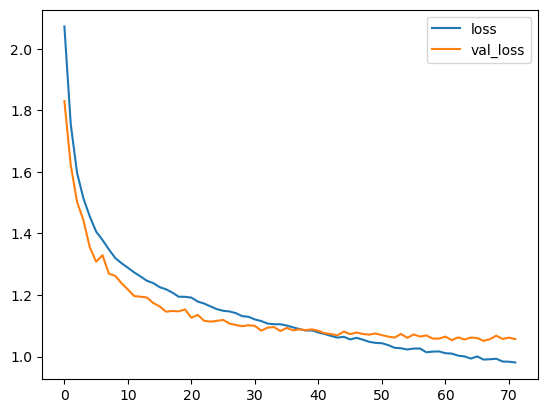

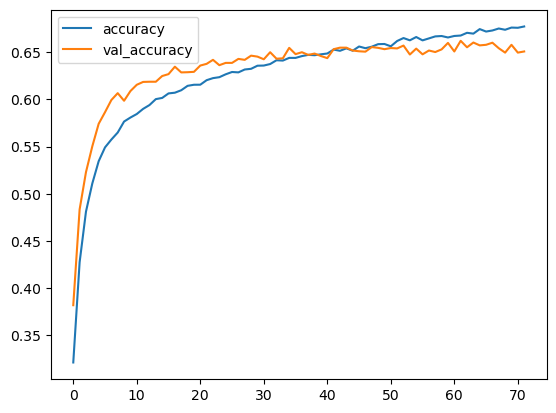

In [95]:
metrics_df = pd.DataFrame(training.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();# The semicolon prevents certain matplotlib items from being printed.

In [96]:
print(training.history)

{'loss': [2.0724737644195557, 1.7548552751541138, 1.5963910818099976, 1.5137584209442139, 1.4550741910934448, 1.406039834022522, 1.3787579536437988, 1.3481589555740356, 1.3203837871551514, 1.3032090663909912, 1.2885246276855469, 1.2733620405197144, 1.2601137161254883, 1.2461466789245605, 1.2386314868927002, 1.2254788875579834, 1.2185604572296143, 1.2078464031219482, 1.194440484046936, 1.1940885782241821, 1.1915029287338257, 1.178784728050232, 1.1722394227981567, 1.1630440950393677, 1.1540862321853638, 1.148759126663208, 1.1465654373168945, 1.141027808189392, 1.1313143968582153, 1.1291347742080688, 1.1205679178237915, 1.115303635597229, 1.1072074174880981, 1.1051251888275146, 1.1050269603729248, 1.1008211374282837, 1.0948710441589355, 1.0895235538482666, 1.0844284296035767, 1.0850039720535278, 1.078257441520691, 1.0731513500213623, 1.0670311450958252, 1.061566948890686, 1.0640814304351807, 1.0557042360305786, 1.0609009265899658, 1.0547891855239868, 1.0478698015213013, 1.044440746307373,

In [97]:
y_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
track_id,,,,,,,,,,,,,,,,
128595,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
128887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
52118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148189,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30606,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131176,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84605,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
test_loss, test_acc = CNN.evaluate(x_test,y_test)

155/155 [==============================] - 2s 11ms/step - loss: 1.0953 - accuracy: 0.6510


In [99]:
test_acc

0.6510080695152283